# Tuning KNN models and testing them against external datasets

## Setting up

In [1]:
# setting up
# imports
import pyreadr
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.cross_decomposition import PLSRegression
from scipy.stats import pearsonr
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.linear_model import ElasticNet

# calculate the mean of the pearson coefficients of multiple variables
def pair_pearsonr(x, y, axis=0): # this will allow us to take the pearson coefficient across two variables
    mx = np.mean(x, axis=axis, keepdims=True)
    my = np.mean(y, axis=axis, keepdims=True)
    xm, ym = x-mx, y-my
    r_num = np.add.reduce(xm * ym, axis=axis)
    r_den = np.sqrt((xm*xm).sum(axis=axis) * (ym*ym).sum(axis=axis))
    r = r_num / r_den
    return r

# plotting setup
# Use LaTeX for graphs' text
plt.rc('text', usetex=True)
# Use the serif font
plt.rc('font', family='serif')

In [3]:
# import data, access pandas df via key "None"
X_Govaere = pyreadr.read_r("datasets/X_Govaere.rds")[None]
X_Hoang = pyreadr.read_r("datasets/X_Hoang.rds")[None]
X_Pantano = pyreadr.read_r("datasets/X_Pantano.rds")[None]

# actual, clinical results
Y_Govaere = pyreadr.read_r("datasets/Y_Govaere.rds")[None]
Y_Hoang = pyreadr.read_r("datasets/Y_Hoang.rds")[None]
Y_Pantano = pyreadr.read_r("datasets/Y_Pantano.rds")[None]

# viper metric, predicted results
Y_viper_Govaere = pyreadr.read_r("datasets/viper_X_Govaere.rds")[None]
Y_viper_Hoang = pyreadr.read_r("datasets/viper_X_Hoang.rds")[None]
Y_viper_Pantano = pyreadr.read_r("datasets/viper_X_Pantano.rds")[None]

In [28]:
# setup tuning procedure
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=5)

# select our training dataset
# TODO: CHANGE THE FOLLOWING 3 LINES
training_dataset = "Pantano"
X = X_Pantano
Y = Y_Pantano

test1 = "Govaere"
X_test1 = X_Govaere
Y_test1 = Y_Govaere

test2 = "Hoang"
X_test2 = X_Hoang
Y_test2 = Y_Hoang

unique, freq = np.unique(Y.iloc[:,0], return_counts=True)
print(f"Unique NAS scores and their corresponding frequency:\n{[f'{(i,j)}' for i, j in zip(unique, freq)]}")
unique, freq = np.unique(Y.iloc[:,1], return_counts=True)
print(f"Unique Fibrosis scores and their corresponding frequency:\n{[f'{(i,j)}' for i, j in zip(unique, freq)]}")


Unique NAS scores and their corresponding frequency:
['(0.0, 32)', '(1.0, 12)', '(2.0, 9)', '(3.0, 11)', '(4.0, 13)', '(5.0, 18)', '(6.0, 12)', '(7.0, 9)']
Unique Fibrosis scores and their corresponding frequency:
['(0.0, 57)', '(1.0, 25)', '(2.0, 25)', '(3.0, 5)', '(4.0, 4)']


In [21]:
params = {'alpha': [0.001,0.01,0.1,1,10,100,1000],
          'l1_ratio': [0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]}

model = GridSearchCV(estimator=ElasticNet(tol=0.001),param_grid = params, cv=5, n_jobs=-1)

## Perform cross validation to find ideal hyperparameters

In [29]:
# Initialize model with GridSearchCV
model = GridSearchCV(estimator=ElasticNet(), param_grid=params, cv=5, n_jobs=-1)

# For storing fold results
best_params_list = []
test_pearson_coeff_fib = []
test_pearson_coeff_nas = []

# K-fold split for the dataset
for i, (train_index, test_index) in enumerate(skf.split(X, Y[Y.columns[1]])):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]

    # Fit model and get best parameters
    model.fit(X_train, Y_train)
    Y_test_hat = model.predict(X_test)

    # Calculate Pearson correlation for each phenotype
    corr_test_fib, _ = pearsonr(Y_test.values[:, 0], Y_test_hat[:, 0])  # fibrosis correlation
    corr_test_nas, _ = pearsonr(Y_test.values[:, 1], Y_test_hat[:, 1])  # NAS correlation
    test_pearson_coeff_fib.append(corr_test_fib)
    test_pearson_coeff_nas.append(corr_test_nas)

    best_params_list.append(model.best_params_)

    print(f"Fold {i}: Best Estimator: {model.best_estimator_}")
    print(f"Best Params: {model.best_params_}")

# Optionally, average correlations over folds
mean_corr_fib = np.mean(test_pearson_coeff_fib)
mean_corr_nas = np.mean(test_pearson_coeff_nas)

print(f"Mean Pearson correlation (Fibrosis): {mean_corr_fib}")
print(f"Mean Pearson correlation (NAS): {mean_corr_nas}")

/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=10.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.144e-01, tolerance: 5.020e-02
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.377e-01, tolerance: 4.562e-02
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: Conve

Fold 0: Best Estimator: ElasticNet(alpha=0.1, l1_ratio=1)
Best Params: {'alpha': 0.1, 'l1_ratio': 1}


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.217e-01, tolerance: 4.326e-02
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.156e-01, tolerance: 4.963e-02
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.333e-01, toler

Fold 1: Best Estimator: ElasticNet(alpha=1, l1_ratio=0.1)
Best Params: {'alpha': 1, 'l1_ratio': 0.1}


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.031e-01, tolerance: 4.379e-02
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.259e-01, tolerance: 4.379e-02
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.466e-01, toler

Fold 2: Best Estimator: ElasticNet(alpha=1, l1_ratio=0.05)
Best Params: {'alpha': 1, 'l1_ratio': 0.05}


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.246e-01, tolerance: 5.146e-02
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.625e-01, tolerance: 4.505e-02
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.566e-01, toler

Fold 3: Best Estimator: ElasticNet(alpha=0.001, l1_ratio=0.05)
Best Params: {'alpha': 0.001, 'l1_ratio': 0.05}


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.596e-01, tolerance: 4.442e-02
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.507e-01, tolerance: 5.118e-02
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.290e-01, toler

Fold 4: Best Estimator: ElasticNet(alpha=1, l1_ratio=0.05)
Best Params: {'alpha': 1, 'l1_ratio': 0.05}


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.177e-01, tolerance: 4.929e-02
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.997e-01, tolerance: 4.586e-02
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.063e-01, toler

Fold 5: Best Estimator: ElasticNet(alpha=1, l1_ratio=0.1)
Best Params: {'alpha': 1, 'l1_ratio': 0.1}


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.453e-01, tolerance: 4.767e-02
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.410e-01, tolerance: 4.883e-02
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.356e-01, toler

Fold 6: Best Estimator: ElasticNet(alpha=0.1, l1_ratio=1)
Best Params: {'alpha': 0.1, 'l1_ratio': 1}


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.554e-01, tolerance: 5.096e-02
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.095e-01, tolerance: 4.384e-02
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.393e-01, toler

Fold 7: Best Estimator: ElasticNet(alpha=1, l1_ratio=0.2)
Best Params: {'alpha': 1, 'l1_ratio': 0.2}


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.065e-01, tolerance: 4.663e-02
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.222e-01, tolerance: 4.707e-02
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.199e-01, toler

Fold 8: Best Estimator: ElasticNet(alpha=0.1, l1_ratio=0.8)
Best Params: {'alpha': 0.1, 'l1_ratio': 0.8}


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.617e-01, tolerance: 5.043e-02
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.410e-01, tolerance: 4.681e-02
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.500e-01, toler

Fold 9: Best Estimator: ElasticNet(alpha=1, l1_ratio=0.1)
Best Params: {'alpha': 1, 'l1_ratio': 0.1}
Mean Pearson correlation (Fibrosis): 0.6470072722091711
Mean Pearson correlation (NAS): 0.6265348313565043


In [30]:
best_params = best_params_list[np.argmax(sum(i,j)/2 for i,j in zip(test_pearson_coeff_fib, test_pearson_coeff_nas))]
best_params

{'alpha': 0.1, 'l1_ratio': 1}

In [31]:
# creating a better all_coeff dataframe

X_shuffled = X.apply(lambda col: np.random.permutation(col.values), axis=0)
X_shuffled.index = X.index # ensure the gene names are maintained

results = [] # initialize list of all results

for i, (train_index, test_index) in enumerate(skf.split(X, Y[Y.columns[1]])):

    # split data
    X_train = X.iloc[train_index]
    X_val = X.iloc[test_index]
    Y_train = Y.iloc[train_index]
    Y_val = Y.iloc[test_index]

    partitions = [[X_train, X_val, X_test1, X_test2, X_shuffled], [Y_train, Y_val, Y_test1, Y_test2, Y], ["Train", "Validation", test1, test2, "Shuffled"]]

    print(f'Evaluating fold {i}')
    # model = loaded_models[i]
    model = ElasticNet(alpha = best_params["alpha"], l1_ratio = best_params["l1_ratio"])
    model.fit(X_train, Y_train)

    for j in range(len(partitions[0])):
        
        Y_hat = model.predict(partitions[0][j])
        corr_nas, _ = pearsonr(partitions[1][j].values[:,0], Y_hat[:,0]) # NAS correlation
        corr_fib, _ = pearsonr(partitions[1][j].values[:,1], Y_hat[:,1]) # fibrosis correlation
        corr_mean = np.mean(pair_pearsonr(partitions[1][j].values, Y_hat)) # mean correlation
        
        results.append({
            "TuningDataset": training_dataset,
            "Fold": f"Fold{i+1}",
            "Partition": partitions[2][j],
            "Phenotype": "Fibrosis", 
            "Pearson_Coefficient": corr_fib,
            "alpha": best_params["alpha"],
            "L1_ratio": best_params["l1_ratio"]
        })
        results.append({
            "TuningDataset": training_dataset,
            "Fold": f"Fold{i+1}",
            "Partition": partitions[2][j],
            "Phenotype": "NAS",
            "Pearson_Coefficient": corr_nas,
            "alpha": best_params["alpha"],
            "L1_ratio": best_params["l1_ratio"]
        })
        results.append({
            "TuningDataset": training_dataset,
            "Fold": f"Fold{i+1}",
            "Partition": partitions[2][j],
            "Phenotype": "Combined",
            "Pearson_Coefficient": corr_mean,
            "alpha": best_params["alpha"],
            "L1_ratio": best_params["l1_ratio"]
        })

    filename = f"models/{training_dataset}_ElasticNet_fold_{i}.pkl"
    with open(filename, 'wb') as file:
        pickle.dump(model, file)
    
    print(f"Model for Fold {i} saved as {filename}")

/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=10.
  warnings.warn(


Evaluating fold 0
Model for Fold 0 saved as models/Pantano_ElasticNet_fold_0.pkl
Evaluating fold 1
Model for Fold 1 saved as models/Pantano_ElasticNet_fold_1.pkl
Evaluating fold 2
Model for Fold 2 saved as models/Pantano_ElasticNet_fold_2.pkl
Evaluating fold 3
Model for Fold 3 saved as models/Pantano_ElasticNet_fold_3.pkl
Evaluating fold 4
Model for Fold 4 saved as models/Pantano_ElasticNet_fold_4.pkl
Evaluating fold 5
Model for Fold 5 saved as models/Pantano_ElasticNet_fold_5.pkl
Evaluating fold 6
Model for Fold 6 saved as models/Pantano_ElasticNet_fold_6.pkl
Evaluating fold 7
Model for Fold 7 saved as models/Pantano_ElasticNet_fold_7.pkl
Evaluating fold 8
Model for Fold 8 saved as models/Pantano_ElasticNet_fold_8.pkl
Evaluating fold 9
Model for Fold 9 saved as models/Pantano_ElasticNet_fold_9.pkl


In [ ]:
# load all models
loaded_models = []
for i in range(0, 10):
    filename = f"models/{training_dataset}_ElasticNet_fold_{i}.pkl"
    with open(filename, 'rb') as file:
        model = pickle.load(file)
        loaded_models.append(model)
    print(f"Loaded model {i} from {filename}")

In [32]:
curr = pd.DataFrame(results)
curr

,TuningDataset,Fold,Partition,Phenotype,Pearson_Coefficient,alpha,L1_ratio
0,Pantano,Fold1,Train,Fibrosis,0.905560,0.1,1
1,Pantano,Fold1,Train,NAS,0.974180,0.1,1
2,Pantano,Fold1,Train,Combined,0.939870,0.1,1
3,Pantano,Fold1,Validation,Fibrosis,0.167984,0.1,1
4,Pantano,Fold1,Validation,NAS,0.472806,0.1,1
...,...,...,...,...,...,...,...
145,Pantano,Fold10,Hoang,NAS,0.721493,0.1,1
146,Pantano,Fold10,Hoang,Combined,0.635525,0.1,1
147,Pantano,Fold10,Shuffled,Fibrosis,0.029343,0.1,1
148,Pantano,Fold10,Shuffled,NAS,-0.078312,0.1,1


In [33]:
p = curr

In [34]:
new = pd.concat([g, h, p])
new
pd.unique(new["TuningDataset"])

array(['Govaere', 'Hoang', 'Pantano'], dtype=object)

In [35]:
# save ** CHECK BEFORE RUNNING
new.to_csv("datasets/ElasticNet_pearson_coefficients.csv", index=False)

In [24]:
g = curr
g

,TuningDataset,Fold,Partition,Phenotype,Pearson_Coefficient,alpha,L1_ratio
0,Govaere,Fold1,Train,Fibrosis,0.883690,1,0.05
1,Govaere,Fold1,Train,NAS,0.913972,1,0.05
2,Govaere,Fold1,Train,Combined,0.898831,1,0.05
3,Govaere,Fold1,Validation,Fibrosis,0.815481,1,0.05
4,Govaere,Fold1,Validation,NAS,0.684953,1,0.05
...,...,...,...,...,...,...,...
145,Govaere,Fold10,Pantano,NAS,0.580506,1,0.05
146,Govaere,Fold10,Pantano,Combined,0.606938,1,0.05
147,Govaere,Fold10,Shuffled,Fibrosis,-0.071577,1,0.05
148,Govaere,Fold10,Shuffled,NAS,-0.097515,1,0.05


## Test with the best model on external and shuffled datasets

In [ ]:
# creating a better all_coeff dataframe
# TODO: CHANGE THE FOLLOWING 6 LINES
test1 = "Hoang"
test2 = "Pantano"

X_test1 = X_Hoang
X_test2 = X_Pantano
Y_test1 = Y_Hoang
Y_test2 = Y_Pantano
X_shuffled = X.apply(lambda col: np.random.permutation(col.values), axis=0)
X_shuffled.index = X.index # ensure the gene names are maintained

results = [] # initialize list of all results

for i, (train_index, test_index) in enumerate(skf.split(X, Y[Y.columns[1]])):

    # split data
    X_train = X.iloc[train_index]
    X_val = X.iloc[test_index]
    Y_train = Y.iloc[train_index]
    Y_val = Y.iloc[test_index]

    partitions = [[X_train, X_val, X_test1, X_test2, X_shuffled], [Y_train, Y_val, Y_test1, Y_test2, Y], ["Train", "Validation", test1, test2, "Shuffled"]]

    print(f'Evaluating fold {i}')
    model = loaded_models[i]

    for j in range(len(partitions[0])):
        
        Y_hat = model.predict(partitions[0][j])
        corr_nas, _ = pearsonr(partitions[1][j].values[:,0], Y_hat[:,0]) # NAS correlation
        corr_fib, _ = pearsonr(partitions[1][j].values[:,1], Y_hat[:,1]) # fibrosis correlation
        corr_mean = np.mean(pair_pearsonr(partitions[1][j].values, Y_hat)) # mean correlation
        
        results.append({
            "TuningDataset": training_dataset,
            "Fold": f"Fold{i+1}",
            "Partition": partitions[2][j],
            "Phenotype": "Fibrosis", 
            "Pearson_Coefficient": corr_fib,
            "alpha": best_params["alpha"],
            'L1_ratio': best_params["l1_ratio"]
        })
        results.append({
            "TuningDataset": training_dataset,
            "Fold": f"Fold{i+1}",
            "Partition": partitions[2][j],
            "Phenotype": "NAS",
            "Pearson_Coefficient": corr_nas,
            "alpha": best_params["alpha"],
            'L1_ratio': best_params["l1_ratio"]
        })
        results.append({
            "TuningDataset": training_dataset,
            "Fold": f"Fold{i+1}",
            "Partition": partitions[2][j],
            "Phenotype": "Combined",
            "Pearson_Coefficient": corr_mean,
            "alpha": best_params["alpha"],
            'L1_ratio': best_params["l1_ratio"]
        })

/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=10.
  warnings.warn(


Evaluating fold 0
Evaluating fold 1
Evaluating fold 2
Evaluating fold 3
Evaluating fold 4
Evaluating fold 5
Evaluating fold 6
Evaluating fold 7
Evaluating fold 8
Evaluating fold 9


In [29]:
curr = pd.DataFrame(results)
curr


,TuningDataset,Fold,Partition,Phenotype,Pearson_Coefficient,K
0,Pantano,Fold1,Train,Fibrosis,0.659339,20
1,Pantano,Fold1,Train,NAS,0.636960,20
2,Pantano,Fold1,Train,Combined,0.648149,20
3,Pantano,Fold1,Validation,Fibrosis,0.345608,20
4,Pantano,Fold1,Validation,NAS,0.438699,20
...,...,...,...,...,...,...
145,Pantano,Fold10,Pantano,NAS,0.635795,20
146,Pantano,Fold10,Pantano,Combined,0.637097,20
147,Pantano,Fold10,Shuffled,Fibrosis,0.020587,20
148,Pantano,Fold10,Shuffled,NAS,0.094817,20


In [31]:
new = pd.concat([results_df, curr])
new
pd.unique(new["TuningDataset"])

array(['Govaere', 'Hoang', 'Pantano'], dtype=object)

In [32]:
new.to_csv("datasets/KNN_pearson_coefficients.csv", index=False)
# results_df = pd.read_csv("datasets/KNN_pearson_coefficients.csv")

## Plot with Mann-Whitney test

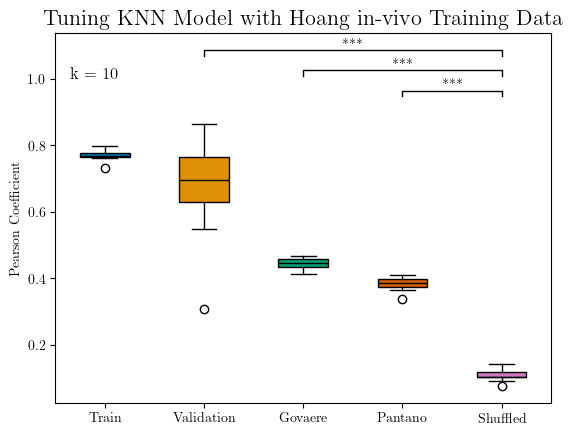

In [153]:
significant_combinations = []

combinations = [(x, 4) for x in [1, 2, 3]]
for combo in combinations:
    data1 = all_pearsons_coeff.iloc[:,combo[0]]
    data2 = all_pearsons_coeff.iloc[:,combo[1]]
    
    # calculate significance
    U, p = stats.mannwhitneyu(data1, data2, alternative='two-sided')
    if p < 0.05:
        significant_combinations.append([combo, p])

# create a set of axes
ax = plt.axes()
# create a boxplot on the axes
bp = ax.boxplot(all_pearsons_coeff, patch_artist=True)
# graph title TODO: CHANGE
ax.set_title(f"Tuning KNN Model with {training_dataset} in-vivo Training Data", fontsize=16)
# label y-axis
ax.set_ylabel("Pearson Coefficient")

xticklabels = all_pearsons_coeff.columns.tolist()
ax.set_xticklabels(xticklabels)

# Change the colour of the boxes to Seaborn's 'pastel' palette
colors = sns.color_palette('colorblind')
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

# Colour of the median lines
plt.setp(bp['medians'], color='k')

# Get the y-axis limits
bottom, top = ax.get_ylim()
y_range = top - bottom

# Significance bars
for i, significant_combination in enumerate(significant_combinations):
    # Columns corresponding to the datasets of interest
    # add one because the df indexing is 0 indexed, but plot is 1 indexed
    x1 = significant_combination[0][0] + 1 
    x2 = significant_combination[0][1] + 1
    # What level is this bar among the bars above the plot?
    level = len(significant_combinations) - i
    # Plot the bar
    bar_height = (y_range * 0.07 * level) + top
    bar_tips = bar_height - (y_range * 0.02)
    plt.plot(
        [x1, x1, x2, x2],
        [bar_tips, bar_height, bar_height, bar_tips], lw=1, c='k'
    )
    # Significance level
    p = significant_combination[1]
    if p < 0.001:
        sig_symbol = '***'
    elif p < 0.01:
        sig_symbol = '**'
    elif p < 0.05:
        sig_symbol = '*'
    text_height = bar_height + (y_range * 0.01)
    plt.text((x1 + x2) * 0.5, text_height, sig_symbol, ha='center', va='bottom', c='k')

# label the hyperparameter value
plt.text(0.65, 1, f'k = {best_neighbors}', fontsize = 12)

#TODO: CHANGE
plt.savefig(f'graphs/KNN_tuning_with_{training_dataset}.png', dpi=200)
plt.show()

In [75]:
significant_combinations

[[(1, 4), 0.00018267179110955002],
 [(2, 4), 0.00018267179110955002],
 [(3, 4), 0.00018267179110955002]]